# Prepear

In [1]:
# https://bamblebam.medium.com/audio-classification-and-regression-using-pytorch-48db77b3a5ec
# The above code will import all the necessary libraries and initialize your device to either CPU or GPU. 

# import torchaudio as ta
# from torch.utils.data import DataLoader
import numpy as numpy

# import numpy as np
# import pandas as pd

# import tqdm

import torch
# from torch import nn
# import torchaudio

# import cnn

if torch.cuda.is_available():
    print('yes')
    device='cuda'
else:
    device='cpu'

import torch
# from cnn import CNNetwork
import torchaudio
import os


import pandas as pd
import numpy as np
# from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from glob import glob
# from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
# import pylab
# import itertools

import nussl
from importlib import reload 
import nussl_fram
reload (nussl_fram)

from nussl_fram import dataset_v3
from sklearn.model_selection import train_test_split

import json # to print dictionary

import shutil
import logging

# from concurrent.futures import ThreadPoolExecutor 

import time

C:\Users\shushu\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


Device is cpu
Device is cpu


In [2]:
start_time = time.time()

In [3]:
# constance
# sr = 8000
# num_features = 129  # number of frequency bins in STFT

sr = 44100
num_features = 1025  # number of frequency bins in STFT

window_length = (num_features-1)*2
hope_length = window_length/4

## Model

In [4]:
# define the building blocks
num_sources = 3  # how many sources to estimate
mask_activation = 'sigmoid'  # activation function for masks
num_audio_channels = 1  # number of audio channels

modules = {
    'mix_magnitude': {},
    'my_log_spec': {
        'class': 'AmplitudeToDB'
    },
    'my_norm': {
        'class': 'BatchNorm',
    },
    'mask': {
        'class': 'Embedding',
        'args': {
            'num_features': num_features,
            'hidden_size': num_features,
            'embedding_size': num_sources,
            'activation': mask_activation,
            'num_audio_channels': num_audio_channels,
            'dim_to_embed': [2, 3]  # embed the frequency dimension (2) for all audio channels (3)
        }
    },
    'my_estimates': {
        'class': 'Mask',
    },
}
# define the topology
connections = [
    ['my_log_spec',    ['mix_magnitude',       ]],
    ['my_norm',        ['my_log_spec',         ]],
    ['mask',           ['my_norm',             ]],
    ['my_estimates',   ['mask', 'mix_magnitude']]
]


# define the outputs
output = ['my_estimates', 'mask']


In [5]:
# configuratia
name = 'cnn_v1'
config = {
    'name': name,
    'modules': modules,
    'connections': connections,
    'output': output
}

print(json.dumps(config, indent=2))

{
  "name": "cnn_v1",
  "modules": {
    "mix_magnitude": {},
    "my_log_spec": {
      "class": "AmplitudeToDB"
    },
    "my_norm": {
      "class": "BatchNorm"
    },
    "mask": {
      "class": "Embedding",
      "args": {
        "num_features": 1025,
        "hidden_size": 1025,
        "embedding_size": 3,
        "activation": "sigmoid",
        "num_audio_channels": 1,
        "dim_to_embed": [
          2,
          3
        ]
      }
    },
    "my_estimates": {
      "class": "Mask"
    }
  },
  "connections": [
    [
      "my_log_spec",
      [
        "mix_magnitude"
      ]
    ],
    [
      "my_norm",
      [
        "my_log_spec"
      ]
    ],
    [
      "mask",
      [
        "my_norm"
      ]
    ],
    [
      "my_estimates",
      [
        "mask",
        "mix_magnitude"
      ]
    ]
  ],
  "output": [
    "my_estimates",
    "mask"
  ]
}


## Prep Data

In [6]:
nussl.utils.seed(0)  # make sure this does the same thing each time

stft_params = nussl.STFTParams(window_length=window_length, hop_length=hope_length)
tfm = nussl.datasets.transforms.Compose([
    nussl.datasets.transforms.PhaseSensitiveSpectrumApproximation(), # np.abs and np.angle
    # nussl.datasets.transforms.MagnitudeSpectrumApproximation(), # magnitude_spectrogram_data - Can replace PhaseApproximation with MagnitudeApproximation
    nussl.datasets.transforms.MagnitudeWeights(),
    nussl.datasets.transforms.ToSeparationModel() # Transpose data from dataset dimentions -> nussl pipline
])

path = os.path.join(os.getcwd(), "audio")
# TODO - update to 44100
uds = dataset_v3(path, min_product = 10, sample_rate=sr, stft_params=stft_params, transform=tfm)
print(f"There are {len(uds)} samples in the data")

There are 1000 samples in the data


In [7]:
item = uds[0]
print(item.keys())
print(item['mix_magnitude'].shape)

dict_keys(['index', 'mix_magnitude', 'ideal_binary_mask', 'source_magnitudes', 'weights'])
torch.Size([260, 1025, 1])


In [8]:
for key in item:
    if torch.is_tensor(item[key]):
        item[key] = item[key].unsqueeze(0).float()

item['mix_magnitude'].shape

torch.Size([1, 260, 1025, 1])

# Demo - Use model

In [9]:
model = nussl.ml.SeparationModel(config)
print(model)

SeparationModel(
  (layers): ModuleDict(
    (my_log_spec): AmplitudeToDB()
    (my_norm): BatchNorm(
      (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mask): Embedding(
      (linear): Linear(in_features=1025, out_features=3075, bias=True)
    )
    (my_estimates): Mask()
  )
)
Number of parameters: 3154952


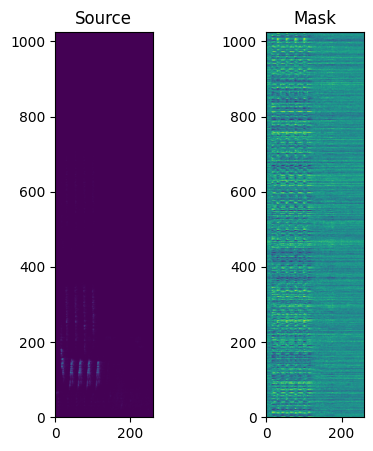

In [10]:
output = model(item)
i = 0
plt.figure(figsize=(5, 5))
plt.subplot(121)
plt.imshow(
    output['my_estimates'][0, ..., 0, i].T.cpu().data.numpy(),
    origin='lower')
plt.title("Source")

plt.subplot(122)
plt.imshow(
    output['mask'][0, ..., 0, i].T.cpu().data.numpy(),
    origin='lower')
plt.title("Mask")
plt.show()

In [11]:
# Exmple train
loss_dictionary = {
    'L1Loss': {
        'weight': 1.0,
        'keys': {
            'my_estimates': 'input',
            'source_magnitudes': 'target',
        }
    }
}

optimizer = torch.optim.Adam(model.parameters(), lr=.001)

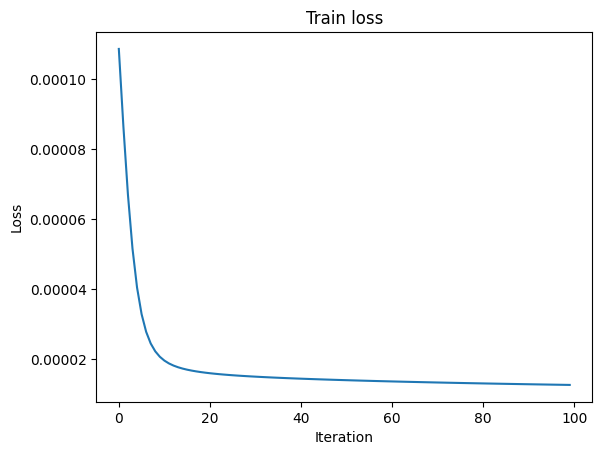

In [12]:
# Train on a single item (overfitting)
train_closure = nussl.ml.train.closures.TrainClosure(
    loss_dictionary, optimizer, model
)

loss_history = []
n_iter = 100

for i in range(n_iter):
    loss_output = train_closure(None, item)
    loss_history.append(loss_output['loss'])

plt.plot(loss_history)
plt.title('Train loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

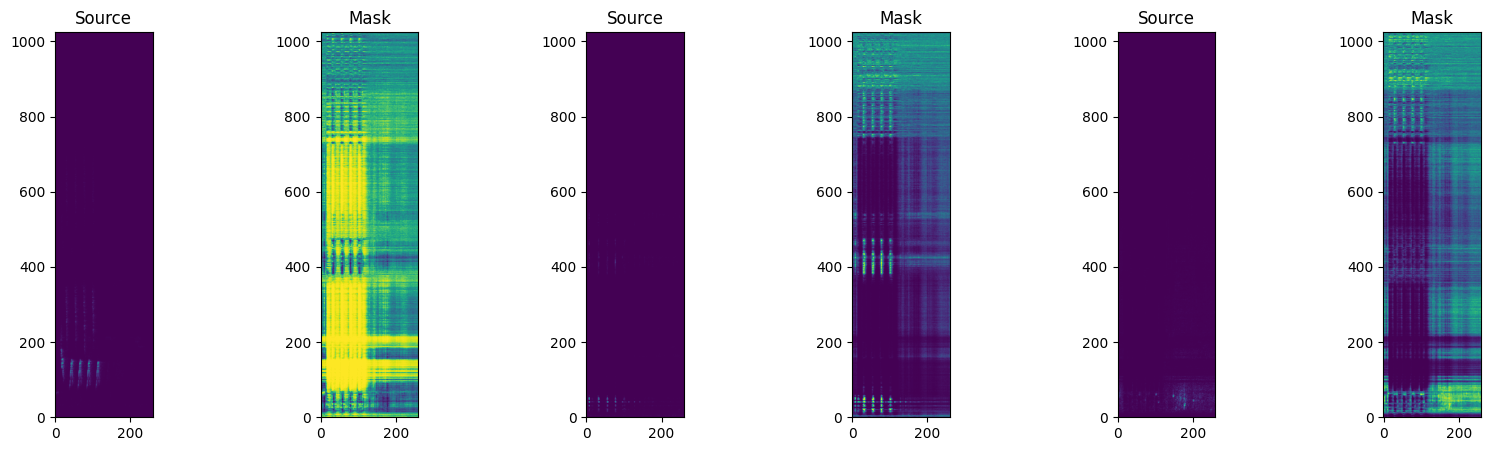

In [13]:
# Mask Visualizetion
output = model(item)
plt.figure(figsize=(20, 5))
j = 1

for i in range(output['my_estimates'].shape[-1]):
    couloms = 2 * output['my_estimates'].shape[-1]

    plt.subplot(1, couloms, j)
    plt.imshow(
        output['my_estimates'][0, ..., 0, i].T.cpu().data.numpy(),
        origin='lower')
    plt.title("Source")

    plt.subplot(1, couloms, j+1)
    plt.imshow(
        output['mask'][0, ..., 0, i].T.cpu().data.numpy(),
        origin='lower')
    plt.title("Mask")

    j = j + 2

plt.show()

# Train

In [14]:
BATCH_SIZE = 5
LEARNING_RATE = 1e-3

OUTPUT_FOLDER = os.path.join(os.getcwd(), 'output')
RESULTS_DIR = os.path.join(OUTPUT_FOLDER, 'results')

NUM_WORKERS = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

shutil.rmtree(os.path.join(RESULTS_DIR), ignore_errors=True)

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# adjust logging so we see output of the handlers
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Put together data
dataloader = torch.utils.data.DataLoader(
    uds, batch_size=BATCH_SIZE
)

# Build our model
model = nussl.ml.SeparationModel(config).to(DEVICE)
print(model)

# # Closures
# Build an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Set up loss functions and closure
# We'll use permutation invariant loss since we don't
# care what order the sine waves get output in, just that
# they are different.
loss_dictionary = {
    'L1Loss': {
        'weight': 1.0,  # In case of multiLoss: sum wigth == 1
        'keys': {
            'my_estimates': 'input',
            'source_magnitudes': 'target',
        }
    }
}

train_closure = nussl.ml.train.closures.TrainClosure(
    loss_dictionary, optimizer, model
)
val_closure = nussl.ml.train.closures.ValidationClosure(
    loss_dictionary, model
)

# Build the engine and add handlers
train_engine, val_engine = nussl.ml.train.create_train_and_validation_engines(
    train_closure, val_closure, device=DEVICE
)
nussl.ml.train.add_validate_and_checkpoint(
    OUTPUT_FOLDER, model, optimizer, uds, train_engine,
    val_data=dataloader, validator=val_engine
)
nussl.ml.train.add_stdout_handler(train_engine, val_engine)

SeparationModel(
  (layers): ModuleDict(
    (my_log_spec): AmplitudeToDB()
    (my_norm): BatchNorm(
      (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mask): Embedding(
      (linear): Linear(in_features=1025, out_features=3075, bias=True)
    )
    (my_estimates): Mask()
  )
)
Number of parameters: 3154952


In [15]:
train_engine.run(dataloader, max_epochs=10) # The higher the trainer

INFO:root:

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0010 
- Training loss:   0.000030 
- Validation loss: 0.000024 
- Epoch took: 0:08:48.414282 
- Time since start: 0:08:48.414323 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to c:\Users\shushu\Desktop\Sorona_Wave\output\checkpoints\best.model.pth. 
Output @ c:\Users\shushu\Desktop\Sorona_Wave\output 

INFO:ignite.engine.engine.Engine:Epoch[1] Complete. Time taken: 00:08:48.417
INFO:ignite.engine.engine.Engine:Engine run starting with max_epochs=1.
INFO:ignite.engine.engine.Engine:Epoch[1] Complete. Time taken: 00:03:33.405
INFO:ignite.engine.engine.Engine:Engine run complete. Time taken: 00:03:33.409
INFO:root:

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0002 / 0010 
- Training loss:   0.000022 
- Validation loss: 0.000021 
- Epoch took: 0:08:18.103285 
- Time since start: 0:17:06.521687 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to c:\Users\shushu\Desktop\Sorona_Wave\output\checkpoints\best.m

State:
	iteration: 2000
	epoch: 10
	epoch_length: 200
	max_epochs: 10
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	model_output: <class 'dict'>
	saved_model_path: c:\Users\shushu\Desktop\Sorona_Wave\output\checkpoints\best.model.pth
	output_folder: c:\Users\shushu\Desktop\Sorona_Wave\output

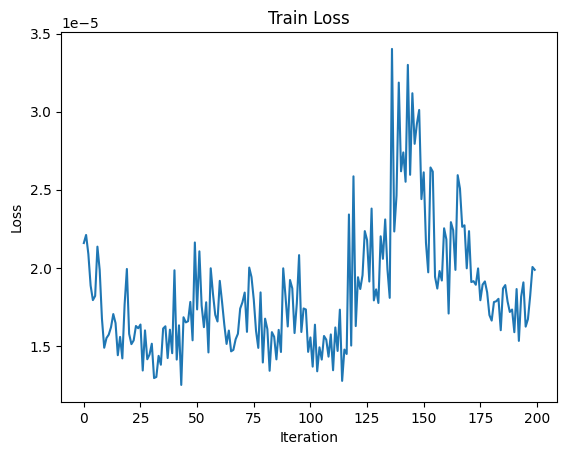

In [16]:
plt.plot(train_engine.state.iter_history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

In [17]:
saved_model = torch.load(train_engine.state.saved_model_path)
print(saved_model.keys())

# # Debug mode:
# print(saved_model['metadata'].keys())
# print(saved_model['state_dict'].keys())

# for key in saved_model['metadata']:
#     print(f"{key}: {saved_model['metadata'][key]}")

# for key in saved_model['state_dict']:
#     print(f"{key}: {saved_model['state_dict'][key]}")

dict_keys(['state_dict', 'config', 'metadata'])


In [18]:
end_time = time.time()
time_taken = end_time - start_time
print(f'Time taken: {time_taken:.4f} seconds')

Time taken: 4066.2889 seconds
